<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 6</h1>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.datasets import load_iris
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, hp, fmin, Trials, rand
from tensorflow.keras import layers, activations

from keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Early stopping</h1>

L'obiettivo del primo esercizio è l'implementazione di un metodo di early stopping, che consenta di fermare al momento adeguato l'allenamento della rete neurale.

Contenuto del dataframe
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

   

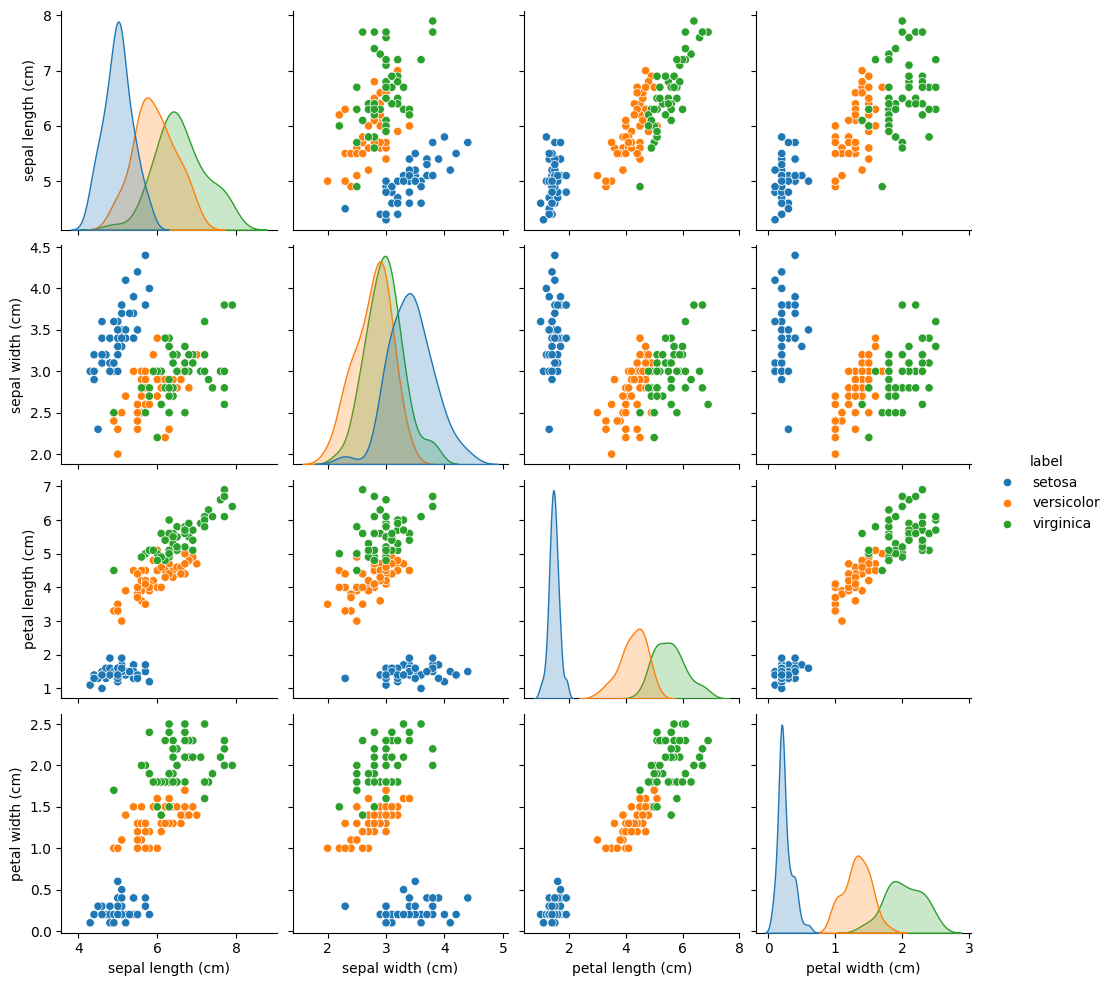

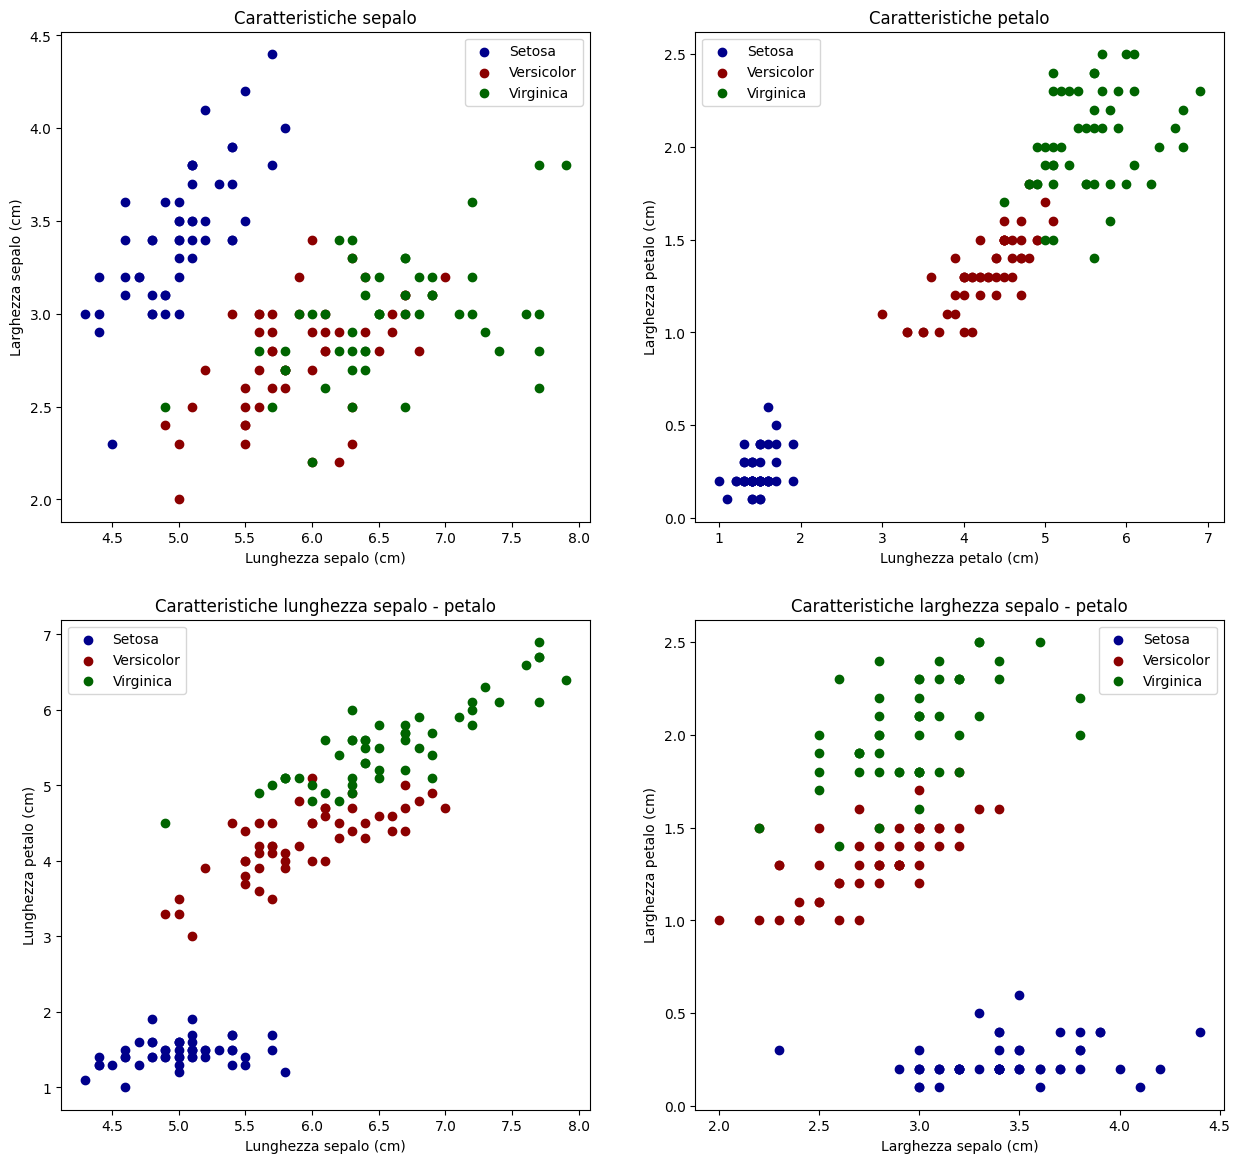

In [50]:
def stampaCorr(asc, ord, titx, tity, titp):
    # Funzione per stampare eventuali correlazioni presenti nel dataset
    fig, ax = plt.subplots(2, 2, figsize = (15, 14))

    # Doppio ciclo per riempire tutti i plot
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 0], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 0], color = 'darkblue', label  = "Setosa")
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 1], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 1], color = 'darkred', label  = "Versicolor")
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 2], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 2], color = 'darkgreen', label  = "Virginica")
            ax[i][j].set_xlabel(titx[2*i+j])
            ax[i][j].set_ylabel(tity[2*i+j])
            ax[i][j].set_title(titp[2*i+j])
            ax[i][j].legend(loc = 'best')


def studyDf(irisDf):
    # Funzione che fa uso del modulo seaborn, che è una libreria di visualizzazione dati
    # pensata per la visualizzazione grafica di dataset. In questo caso per andare a studiare le 
    # correlazioni fra le varie colonne basta usare il comando ".pairplot(...)" che genera una matrice
    # di scatter plot in cui ciascuna variabile numerica è messa in rapporto con le altre. Sono da fornire,
    #  come argomenti della funzione in questione il dataset da confrontare ed il fatto che i dati vengono 
    # colorati in base al valore della colonna 'label'
    sns.pairplot(irisDf, hue='label')
    plt.show()


# La prima fase di questo esercizio consiste nell'importare il dataset IRIS, che
# restitusce un dizionario le cui flag sono:
#       - 'data': matrice con lughezze sepali e petali
#       - 'target': etichetta del fiore corrispondente
#       - 'feature_names': elenco di stringhe per nomi dati
#       - 'target_names': elenco di stringhe per nomi fiori
# In particolare 'data' è un array bidimensionale di forma (150, 4) in cui ogni riga
# rappresenta un fiore, e ogni colonna rappresenta una delle caratteristiche dello stesso. 
# Per ogni fiore sono quindi prese in considerazione 4 features, ossia lunghezza e larghezza
# del sepalo e del petalo.
iris = load_iris()
# Per convertire quanto ottenuto come output della funzione load_iris() in un oggetto di pandas 
# (che è comodo per gestiri tali tipologie di dataset) è possibile specificare nel costruttore 
# del dataFrame i dati contenuti in iris (ossia lunghezza e larghezza di sepali e petali di ciascun 
# fiore) ed i nomi delle colonne.
irisDf = pd.DataFrame(data = iris.data, columns = iris.feature_names)
# In un secondo momento vanno aggiunte delle altre colonne al dataframe, ossia l'etichetta numerica 
# target, che indica la classe di appartenenza del fiore, ed il nome della classe in questione.
# Questa operazione non può essere effettuata in fase di inizializzazione.

# Stampo a video il contenuto del dataset
irisDf['label'] = iris.target_names[iris.target]
print("Contenuto del dataframe")
print(irisDf)
studyDf(irisDf)

# Stampo a video eventuali correlazioni fra i dati del dataset individuate manualmente. Ciò che notiamo è 
# che la classificazione della classe setosa ci possiamo aspettare che sia più semplice rispetto alla 
# distinzione fra le altre due classi, poichè si notano degli evidenti cluster riferiti solo alla sottospecie setosa
# Convertiamo inoltre le labels per lavorare con one-hot encoding, ossia con tre colonne le quali presentano true o False
# per indicare o meno l'appartenenza a ciascuna delle tre classi
irisDf = pd.get_dummies(irisDf, columns=['label'], prefix='label')

asc = [0, 2, 0, 1]
ord = [1, 3, 2, 3]
titx = ["Lunghezza sepalo (cm)", "Lunghezza petalo (cm)", "Lunghezza sepalo (cm)", "Larghezza sepalo (cm)"]
tity = ["Larghezza sepalo (cm)", "Larghezza petalo (cm)", "Lunghezza petalo (cm)", "Larghezza petalo (cm)"]
titp = ["Caratteristiche sepalo", "Caratteristiche petalo", "Caratteristiche lunghezza sepalo - petalo", "Caratteristiche larghezza sepalo - petalo"]

stampaCorr(asc, ord, titx, tity, titp)

Epoch 1/200


/home/filippo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.2964 - loss: 1.1206 - val_accuracy: 0.2917 - val_loss: 1.0527
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3329 - loss: 1.0360 - val_accuracy: 0.3958 - val_loss: 0.9888
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4987 - loss: 0.9661 - val_accuracy: 0.7708 - val_loss: 0.9231
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8885 - loss: 0.8912 - val_accuracy: 0.8125 - val_loss: 0.8434
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8003 - loss: 0.8275 - val_accuracy: 0.9167 - val_loss: 0.7761
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8850 - loss: 0.7523 - val_accuracy: 0.7292 - val_loss: 0.7018
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6832 - loss: 0.6918 - val_accuracy: 0.7083 - val_loss: 0.6377
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6997 - loss: 0.6314 - val_accuracy: 0.7083 - val_loss: 0.5495
Epo

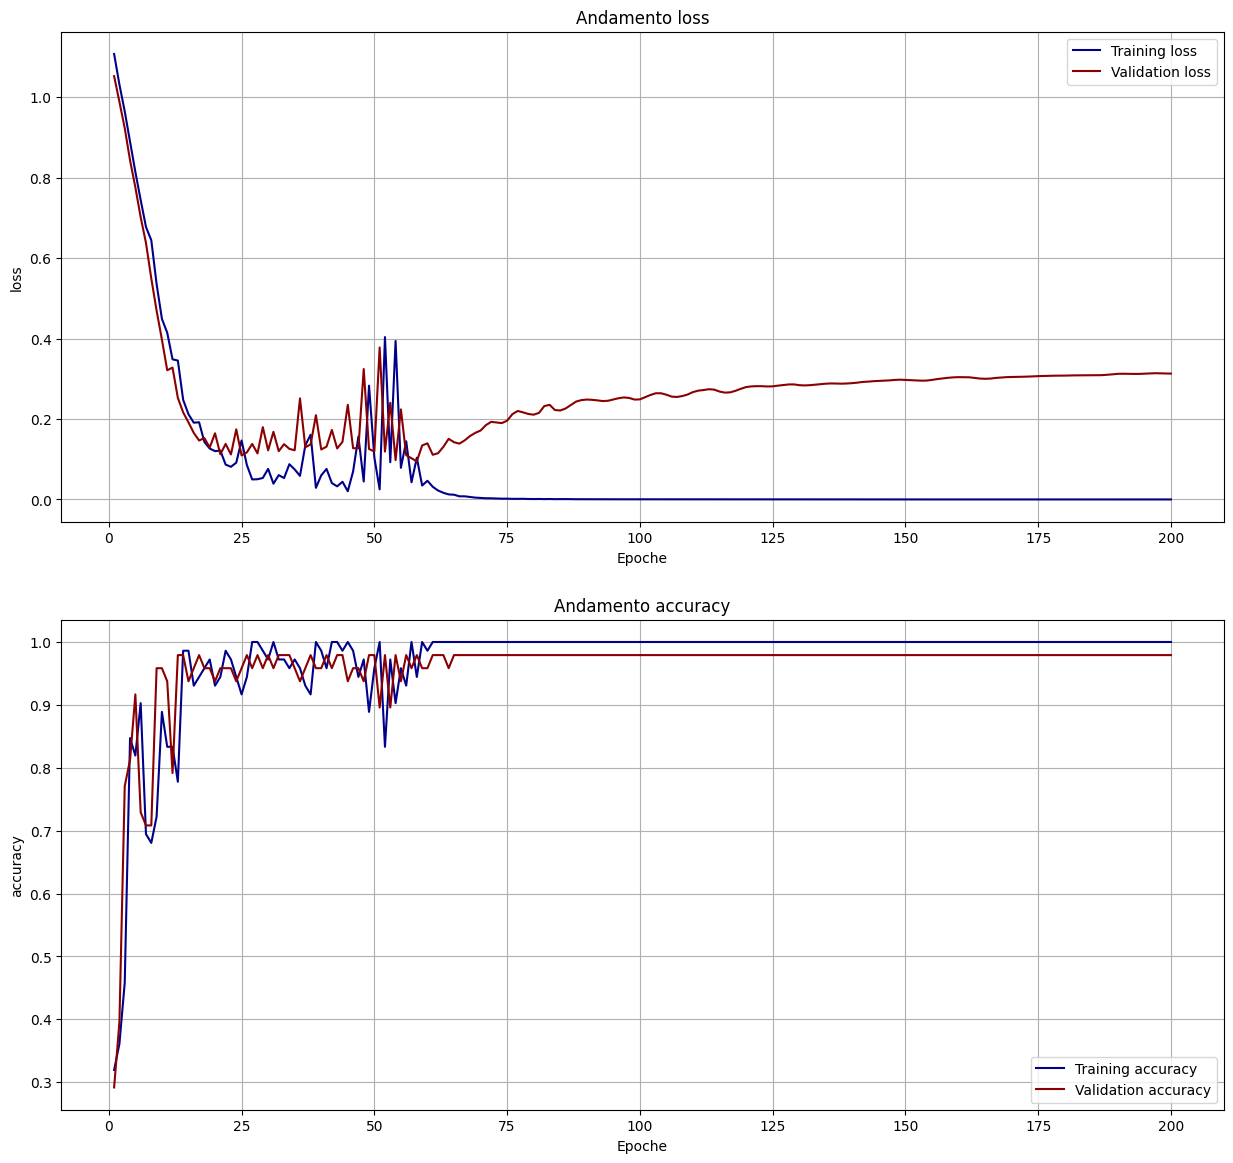

In [51]:
def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()


# Creazione del modello. Dato che il problema che stiamo prendendo in considerazione è un 
# problema di classificazione, è necessario che i nodi di output siano tanti quanti sono le 
# classi del dataset in analisi. Per tali componenti della rete vogliamo utilizzare come funzione 
# d'attivazione 'softmax', in modo tale che sia possibile identificare quale sia la predizione più 
# probabile del modello.
def buildMod():
    # Funzione per creare il modello. Stiamo pensando di utilizzare un DNN con diversi layers nascosti 
    # in modo tale da rendere eccessivamente complicato il modello e poter lavorare con early stopping
    # techniques. Il layer di output conterrà tre soli nodi, per valutare quale sia la classe a cui 
    # appartiene con maggior probabilità il campione in analisi.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    return model


# Divido dataset in allenamento e validation, per poter allenare in modo adeguato il modello
# All'interno dei dati di training vado a selezionare quali sono gli input del modello e quali 
# invece gli output auspicabili. Random state consente di specificare il seme del generatore di 
# numeri casuali utilizzato per effettuare lo splitting del dataset grazie al metodo .sample()
trainS = irisDf.sample(frac = 0.8, random_state=1)      # Seleziona 80% dataset
valS = irisDf.drop(trainS.index)                        # Identifica il restante 20%

# Per estrarre dati da dataframe pandas utilizzo il metodo iloc, che consente di lavorare con 
# indici riga ed indici colonna invece di usare le labels
trIn = trainS.iloc[:, 0:4]
trOut = trainS.iloc[:, 4:7]


# Definisco un modello e lo compilo utilizzando come ottimizzatore Adam ed invece come funzione di 
# perdita 'categorical_crossentropy'. Alleno la rete per 200 epoche utilizzando come dataset di validazione
# il 40 % del dataset di input. Questa tecnica viene utilizzata per ridurre l'overfitting ed è un buon approccio 
#  quando non si vuole fare uno split manuale dei dati, ma comunque è necessario monitorare le prestazioni del modello 
# su dati non visti durante l’allenamento
mod1 = buildMod()
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist1 = mod1.fit( trIn, trOut, epochs=200, validation_split=0.4, batch_size=32)
plotTrInfo(hist1)

/home/filippo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.3355 - loss: 1.1166 - val_accuracy: 0.6042 - val_loss: 1.0735
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5629 - loss: 1.0603 - val_accuracy: 0.7083 - val_loss: 1.0037
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.6879 - loss: 0.9947 - val_accuracy: 0.7083 - val_loss: 0.9187
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6957 - loss: 0.8970 - val_accuracy: 0.7083 - val_loss: 0.8360
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7075 - loss: 0.8120 - val_accuracy: 0.7083 - val_loss: 0.7423
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6879 - loss: 0.7214 - val_accuracy: 0.7083 - val_loss: 0.6299
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6489 - loss: 0.6279 - val_accuracy: 0.7083 - val_loss: 0.5216
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6411 - loss: 0.5411 - val_accuracy: 0.7083 - val_los

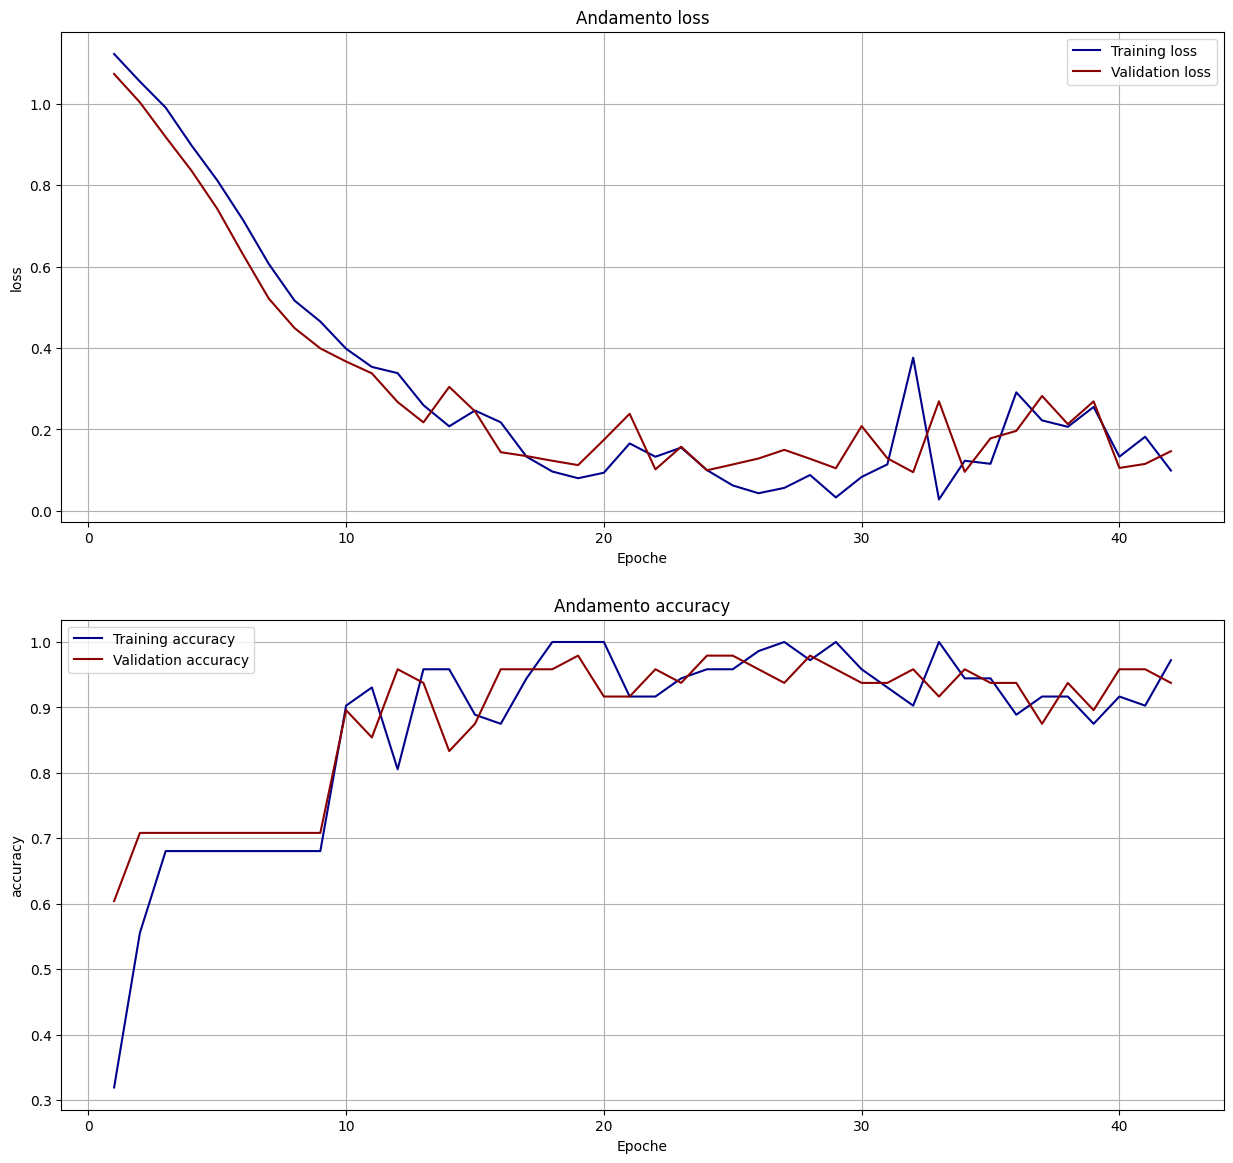

In [52]:
# Stampando la loss function al punto precedente risulta evidente come il modello vada 
# in overtraining, dato che la validation loss function aumenta mano a mano che il modello
# viene allenato (ossia ne peggiorano le capacità predittive). Per evitare un eccessivo 
# adattamento ai dati di triaining del modello, proviamo a riproporre quanto fatto in precedenza, 
# ma tentando di stoppare l'allenamento al punto giusto (early stopping). Per far questo utilizziamo
# la callback EarlyStopping di Keras, che interrompe il traning quando la performance sul dataset di 
# validazione smette di funzionare. 

def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()

mod2 = buildMod()
mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ulitizzo il callback EarlyStoppig per arrestare l'allenamento del modello nel momento in cui la
# performance della rete non continua a migliorare sul dataset di validazione. In particolare sono 
# stati esplicitati due aspetti, ossia:
#       1 --> la metrica da monitorare, in questo caso la loss-function sul dataset di validazione
#       2 --> 'patience', ossia il numero di cicli d'allenamento che sono ammissibili senza alcun miglioramento 
#              modello stesso
early_stop = EarlyStopping(monitor='val_loss', patience=10)
hist2 = mod2.fit(trIn, trOut, epochs=200, validation_split=0.4, callbacks=[early_stop], batch_size=32)

# Stampo a video quanto ottenuto
plotTrInfo(hist2)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


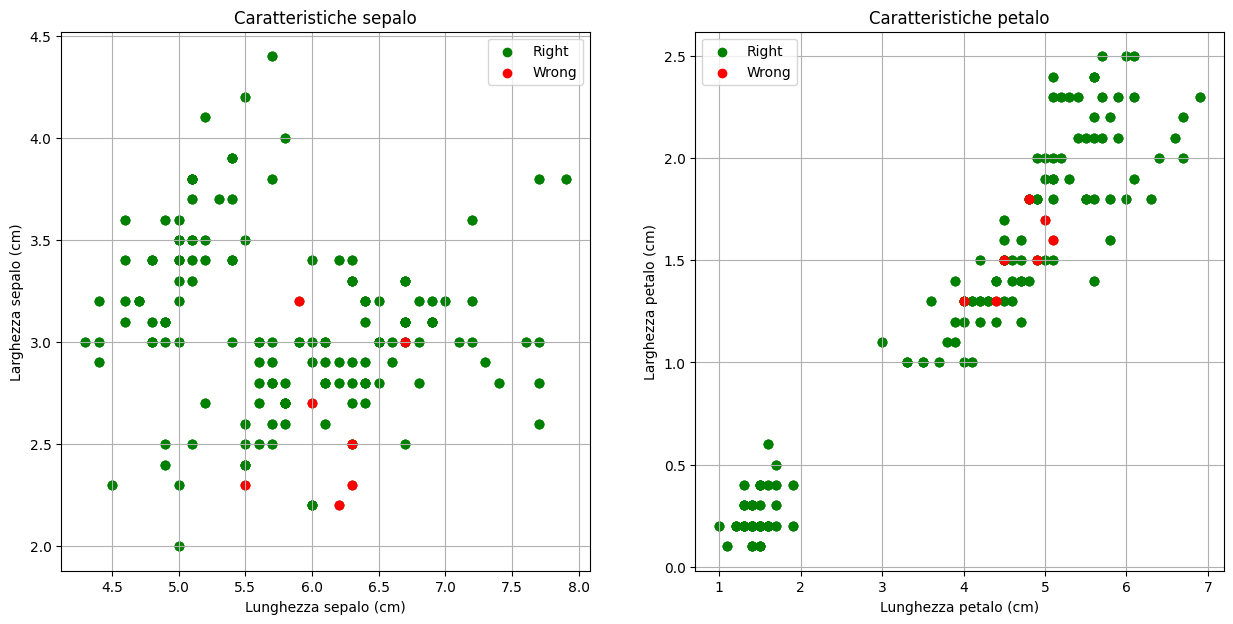

In [ ]:
def mapPred(pred):
    # Funzione per avere delle predizioni conformi a label iniziali (con hot encoding)
    prM = np.zeros(shape=pred.shape)
    
    for i, k in enumerate(pred):
        prM[i, np.argmax(k)] = 1
    
    return prM


def printPred(titles, label, pred):
    # Stampo le predizioni del modello. In primo luogo identifico quali siano le predizioni
    # esatte ed invece quali siano quelle sbagliate
    mask = pred == y
    xTr = x[mask]
    xFl = x[~mask]

    fig, ax = plt.subplots(1, 2, figsize = (15, 7))

    for i, tit in enumerate(titles):
        ax[i].scatter(xTr.iloc[:,2*i], xTr.iloc[:,2*i+1], color = 'green', label = 'Right')
        ax[i].scatter(xFl.iloc[:,2*i], xFl.iloc[:,2*i+1], color = 'red', label = 'Wrong')
        
        ax[i].set_title(tit)
        ax[i].set_xlabel(label[2*i])
        ax[i].set_ylabel(label[2*i+1])

        ax[i].legend(loc = 'best')
        ax[i].grid(True)

    plt.show()



# Andiamo a effettuare delle predizioni utilizzando tutto il dataset a nostra disposizione. Per vedere
# se la predizione è stata azzeccata o meno, coloro di verde le predizioni esatte e di rosso quelle errate
# Così facendo possiamo osservare quanto sospettato in partenza, ossia che la regione problematica per la
# predizione è quella in cui si ha "sovrapposizione" fra i dati delle classi virginica e versicolor
x = irisDf.iloc[:, 0:4]
pred = mapPred(mod2.predict(x))
y = np.array(irisDf.iloc[:, 4:7])

# Stampo i due grafici con le predizioni, errate e non
label = ["Lunghezza sepalo (cm)", "Larghezza sepalo (cm)", "Lunghezza petalo (cm)", "Larghezza petalo (cm)"]
titp = ["Caratteristiche sepalo", "Caratteristiche petalo"]
printPred(titp, label, pred)


plt.show()